# Aperture Photometry Program
### Photometry Program which automatically subtracts the background from the measurement
This program computes the sloan g, r, and g-r magnitudes of star P Cygni by measuring the photometric intensities of P Cygni and 3 calibration stars. The data was taken at the New Haven Leitner Family Observatory and Planetarium (LFOP) on October 12, at UTC: +1:00 with clear skies and decent seeing by observer Elko Gerville-Reache. The main telescope used was a 16’’ f/8.9 RCOS ritchey-chretien mounted on a guided equatorial mount. The filters used were photometric sloan-g (400 - 550 nm) and sloan-r (550 - 700 nm), corresponding to green and red light respectively.  P Cygni has J2000 celestial coordinates RA: 21:51:41 and DEC: +43:08:02.

In [1]:
# computational
import numpy as np
# plotting
import matplotlib.pyplot as plt
# import fits
from astropy.io import fits
# photometry
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.aperture import ApertureStats

In [2]:
# read in the data into Python
def read_fits(file):
    '''reads in astronomical .fits file and returns header and data
    ---------------------------------------------------------------
    file [string]: directory of the file to be read in
    '''
    hdu = fits.open(file)
    # separate header and data into arrays
    header = hdu[0].header
    data = hdu[0].data
    return header, data

def load_data(directory, numb_files):
    '''automates loading in multiple .fits files into Python
    --------------------------------------------------------
    directory [string]: directory with data files; ei: directory = 'folder/filename{}.fit' 
        {} is a stand-in for the file number, ei: filename01.fit, filename02.fit, etc...
    numb_files [integer]: number of files
    OUTPUT [list]: headers and data files stored in lists
    '''
    # create empty lists
    headers, data_list = [], []
    # loop through number of files
    for i in range(1, numb_files+1):
        # read in data
        header, data = read_fits(directory.format(i))
        # save data to lists
        headers.append(header)
        data_list.append(data)
    return headers, data_list

In [3]:
# load-in red and green filter data of P Cygni
header_PCygni_r, PCygni_red = load_data('vz_red_r_0000{}.fit', 5)
header_PCygni_g, PCygni_grn = load_data('vz_green_r_0000{}.fit', 5)

In [4]:
# display the header of the first image (index 0) of P Cygni in the red filter
print(header_PCygni_r[0])

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 2249 / length of data axis 1                          NAXIS2  =                 1799 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BZERO   =                   0. / offset data range to that of unsigned short    BSCALE  =                   1. / default scaling factor                         DATE    = '2024-02-06T06:24:10' / UTC date that FITS file was created           DATE-OBS= '2023-10-11T21:31:41.526000' / YYYY-MM-DDThh:mm:ss observation start, EXPTIME =                  40. / Exposur

In [5]:
# display the data of the first image (index 0) of P Cygni in the red filter
print(PCygni_red[0])

[[ 0.00256351  0.03749141  0.03678951 ...  0.01395163  0.01348996
   0.01249239]
 [ 0.00112918  0.02138171  0.0298128  ...  0.01394336  0.01383011
   0.0135595 ]
 [ 0.00051883  0.01630243  0.02405492 ...  0.01452726  0.01385671
   0.01367537]
 ...
 [-0.00302127  0.00891128  0.01004043 ...  0.01297018  0.01260394
   0.01297015]
 [-0.00198367  0.0094606   0.00866714 ...  0.01098651  0.01141375
   0.01196307]
 [-0.00125125  0.01190203  0.0091249  ...  0.01300067  0.01168841
   0.01190203]]


In [6]:
# function to visualize the data and photometry apertures
def imshow(image, **kwargs):
    '''creates imshow plot of the data with optional photometry apertures overplotted
    --------------------------------------------------------------------------------------
    image [numpy array]: array of data
    **kwargs:
    aperture [object]: CircularAperture object
    anulus [object]: CircularAnnulus object
    OUTPUT [matplotlib imshow plot]: displays data in imshow plot
    '''
    plt.figure(figsize = (9,9))
    # plot data with proper scaling
    plt.imshow(image, vmin=np.percentile(image, 5), vmax=np.percentile(image, 95))
    # optional aperture plotting
    if 'aperture' in kwargs:
        aperture = kwargs['aperture']
        aperture.plot(color = 'w')
    # optional annulus aperture plotting
    if 'anulus' in kwargs:
        annulus_aperture = kwargs['anulus']
        annulus_aperture.plot(color = 'r')
    plt.show()

## P Cygni Sloan Red Band Data

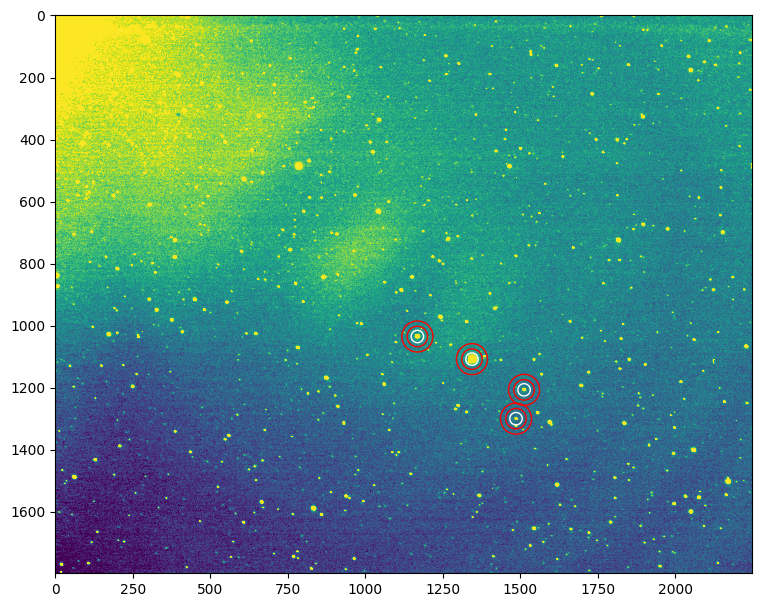

In [7]:
# center positions of each circular aperture for P Cygni red band data
positions_red = [(1344.0, 1108.0), (1168.0, 1035.0), (1486.0, 1300.0), (1512.0, 1207.0)]
# create apertures
apertures_red = CircularAperture(positions_red, r = 20)
# create annulus apertures
annulus_aperture_red = CircularAnnulus(positions_red, r_in=33, r_out=50)
# display data with apertures
imshow(PCygni_red[0], aperture = apertures_red, anulus = annulus_aperture_red)

In [18]:
def get_magnitude(m2, F1, F2):
    '''computes target star magnitude based on target and calibration star fluxes and calibration magnitudes
    --------------------------------------------------------------------------------------------------------------
    m2 [numpy array]: known magnitudes of calibration stars
    f1 [numpy array]: measured flux of target star
    f2 [numpy array]: measured fluxes of calibration stars
    OUTPUT [numpy array]: Nx1 array of photometric magnitudes of target star; one measurement per calibration star
    '''
    magnitude = m2 + 2.5*np.log10(F2/F1)
    return magnitude

def GetPhotometryMagnitude(data, calibration_mag, positions, r, r_in, r_out):
    '''performs aperture photometry on a set of targets and returns data table and magnitudes
    data [numpy array]: array of data
    calibration_mag [array]: array of known magnitudes of each calibration star
    positions [array]: array of center positions of each circular aperture
    r [float]: radius of circular aperture
    r_in, r_out [float]: radii of inner and outer aperture rings for background subtraction
    OUTPUT [table, array]: outputs photometry table and array of magnitudes
    '''
    # perform photometry
    # create apertures
    apertures = CircularAperture(positions, r = r)
    # create annulus apertures
    annulus_apertures = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    # calculate average background 
    aper_stats = ApertureStats(data, annulus_apertures)
    bkgnd_mean = aper_stats.mean
    # calculate total background noise
    aperture_area = apertures.area_overlap(data)
    total_bkgnd = bkgnd_mean * aperture_area
    # perform aperture photometry
    phot_table = aperture_photometry(data, apertures)
    # subtract background from photometry
    phot_bkgndsub = phot_table['aperture_sum'] - total_bkgnd
    # add new data to table
    phot_table['total_bkgnd'] = total_bkgnd
    phot_table['aperture_sum_bkgndsub'] = phot_bkgndsub
    # print table
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    print(phot_table)
    
    # compute magnitude
    # calculate number of calibration stars
    N = len(phot_table['aperture_sum_bkgndsub'])-1
    # create numpy array of N copies of target flux
    flux_target = np.ones((N,1)) * np.array(phot_table['aperture_sum_bkgndsub'][0])
    # create numpy array of calibration star fluxes
    flux_calibration = np.array(phot_table['aperture_sum_bkgndsub'][1:]).reshape(N,1)
    # ensure calibration star magnitudes have correct shape
    calibration_mag = calibration_mag.reshape(N,1)
    # compute magnitudes
    magnitudes = get_magnitude(calibration_mag, flux_target, flux_calibration)
    
    return phot_table, magnitudes

def GetAverageMagnitude(data_list, calibration_mag, positions, r, r_in, r_out):
    '''performs aperture photometry on a data set and computes the average magnitude and errors
    -------------------------------------------------------------------------------------------
    data_list [list]: list of data numpy arrays
    calibration_mag [array]: array of known magnitudes of each calibration star
    positions [array]: array of center positions of each circular aperture
    r [float]: radius of circular aperture
    r_in, r_out [float]: radii of inner and outer aperture rings for background subtraction
    OUTPUT [float]: average magnitude and error (mean of standard deviation) of data set
    '''
    magnitudes = []
    # loop through each data file
    for data in data_list:
        # compute photometry and magnitudes
        table, mag = GetPhotometryMagnitude(data, calibration_mag, positions, r, r_in, r_out)
        # append magnitudes
        magnitudes.append(mag)
    # compute mean of magnitudes
    mean = np.mean(magnitudes)
    # compute error by calculating mean of standard deviation
    std = np.std(magnitudes)
    error = std / np.sqrt(len(magnitudes))
    print('\n average magnitude: {} {} {}'.format(mean, '±', error))
    return mean, error

In [9]:
# known magnitudes of calibration stars in sloan red filter
calibration_mags_red = np.array((11.442, 12.806, 13.274))

In [10]:
# compute photometry for P Cygni in red band
PCygni_mag_red, PCygni_error_red = GetAverageMagnitude(PCygni_red, calibration_mags_red, positions_red, 29, 35, 50)

 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgndsub
      pix     pix                                                 
--- ------- ------- ------------ ----------- ---------------------
  1    1344    1108    91.764507   35.842263             55.922244
  2    1168    1035    42.881673   35.499317             7.3823564
  3    1486    1300    35.621007   33.846381              1.774626
  4    1512    1207    36.227829   34.203615              2.024214
 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgndsub
      pix     pix                                                 
--- ------- ------- ------------ ----------- ---------------------
  1    1344    1108    103.78231   43.471535             60.310776
  2    1168    1035    50.261501   42.984631               7.27687
  3    1486    1300    43.447737   41.765025             1.6827122
  4    1512    1207    44.078766   42.014327             2.0644392
 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgn

## P Cygni Sloan Green Band Data

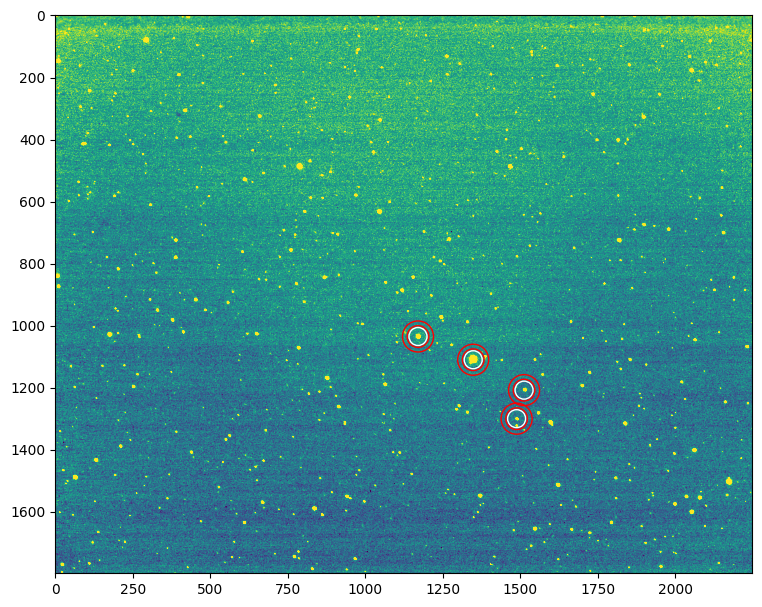

In [11]:
# center positions of each circular aperture for P Cygni green band data
positions_grn = [(1348.0, 1110.0), (1170.0, 1035.0), (1488.0, 1300.0), (1512.0, 1208.0)]
# create apertures
apertures_grn = CircularAperture(positions_grn, r = 29)
# create annulus apertures
annulus_aperture_grn = CircularAnnulus(positions_grn, r_in=35, r_out=50)
# display data along with photometry apertures
imshow(PCygni_grn[0], aperture = apertures_grn, anulus = annulus_aperture_grn)

In [12]:
# known magnitudes of calibration stars in sloan green filter
calibration_mags_grn = np.array((11.807, 13.103, 13.768)).reshape(3,1)

In [13]:
# compute photometry for P Cygni in green band
PCygni_mag_grn, PCygni_error_grn = GetAverageMagnitude(PCygni_grn, calibration_mags_grn, positions_grn, 29, 35, 50)

 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgndsub
      pix     pix                                                 
--- ------- ------- ------------ ----------- ---------------------
  1    1348    1110    75.774849   30.952283             44.822567
  2    1170    1035    37.282822   30.914273             6.3685489
  3    1488    1300    31.359782   29.772749             1.5870339
  4    1512    1208    31.733071   29.997946             1.7351254
 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgndsub
      pix     pix                                                 
--- ------- ------- ------------ ----------- ---------------------
  1    1348    1110    69.486209   23.474802             46.011408
  2    1170    1035    29.483185   23.472391             6.0107938
  3    1488    1300    23.735604   22.276203             1.4594011
  4    1512    1208    24.347687    22.51838             1.8293069
 id xcenter ycenter aperture_sum total_bkgnd aperture_sum_bkgn

## Print Out Final Statistics

In [14]:
# compute g-r band magnitude
PCygni_g_minus_r_mag = PCygni_mag_grn - PCygni_mag_red
# add errors together
final_error = PCygni_error_grn + PCygni_error_red
# print final measurements
print('P Cygni sloan g band magnitude: {} {} {}'.format(PCygni_mag_grn, '±', PCygni_error_grn))
print('P Cygni sloan r band magnitude: {} {} {}'.format(PCygni_mag_red, '±', PCygni_error_red))
print('P Cygni sloan g-r magnitude:  {} {} {}'.format(PCygni_g_minus_r_mag, '±', final_error))

P Cygni sloan g band magnitude: 9.717072482132858 ± 0.1789999622775643
P Cygni sloan r band magnitude: 9.263106967324354 ± 0.1332102332682829
P Cygni sloan g-r magnitude:  0.45396551480850356 ± 0.31221019554584717


## Comparison to AstroImageJ Photometry
The magnitudes computed in this program agree very closely with the magnitudes computed with the AstroImageJ program which also has background subtracted photometry capabilities. The final reported magnitudes using AstroImageJ are reported below:

In [17]:
print('AstroImageJ P Cygni sloan g band magnitude: {} {} {}'.format(9.7164668, '±', 0.052676643))
print('AstroImageJ P Cygni sloan r band magnitude: {} {} {}'.format(9.2645205, '±', 0.047601246))
print('AstroImageJ P Cygni sloan g-r magnitude:  {} {} {}'.format(0.4519, '±', 0.100277890571))

AstroImageJ P Cygni sloan g band magnitude: 9.7164668 ± 0.052676643
AstroImageJ P Cygni sloan r band magnitude: 9.2645205 ± 0.047601246
AstroImageJ P Cygni sloan g-r magnitude:  0.4519 ± 0.100277890571
